<a href="https://colab.research.google.com/github/Qqqsse/HW3-seq2seq-LSTM-and-seq2seq-VAE/blob/main/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

使用裝置: cuda
✓ 使用字體: DejaVu Sans
Seq2Seq LSTM vs VAE - V7 (遵守作業要求 + 學習率熱身)

Step 1-4: Data Preparation
--------------------------------------------------------------------------------
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted successfully!
✓ Data loaded successfully!
✓ Data: 584911 records, 26074 students
✓ Sequences: (461660, 4, 4)
✓ Data loaders ready (batch_size=128)

Step 5: Train Seq2Seq LSTM (V7: Warmup + Full Training)
--------------------------------------------------------------------------------
Model: Seq2Seq LSTM (原始架構)
  - Parameters: 35,137

訓練配置 (V7):
  - 初始學習率: 0.001
  - 熱身 epochs: 3
  - 總 epochs: 30
Epoch [1/30], LR: 0.000333, Train: 0.7542, Valid: 0.7331
Epoch [5/30], LR: 0.001000, Train: 0.7369, Valid: 0.7303
Epoch [10/30], LR: 0.001000, Train: 0.7312, Valid: 0.7319
Epoch [15/30], LR: 0.001000, Train: 0.7234, Valid: 0.7313
Epoch [20/30], LR: 0.001000, Train: 0.

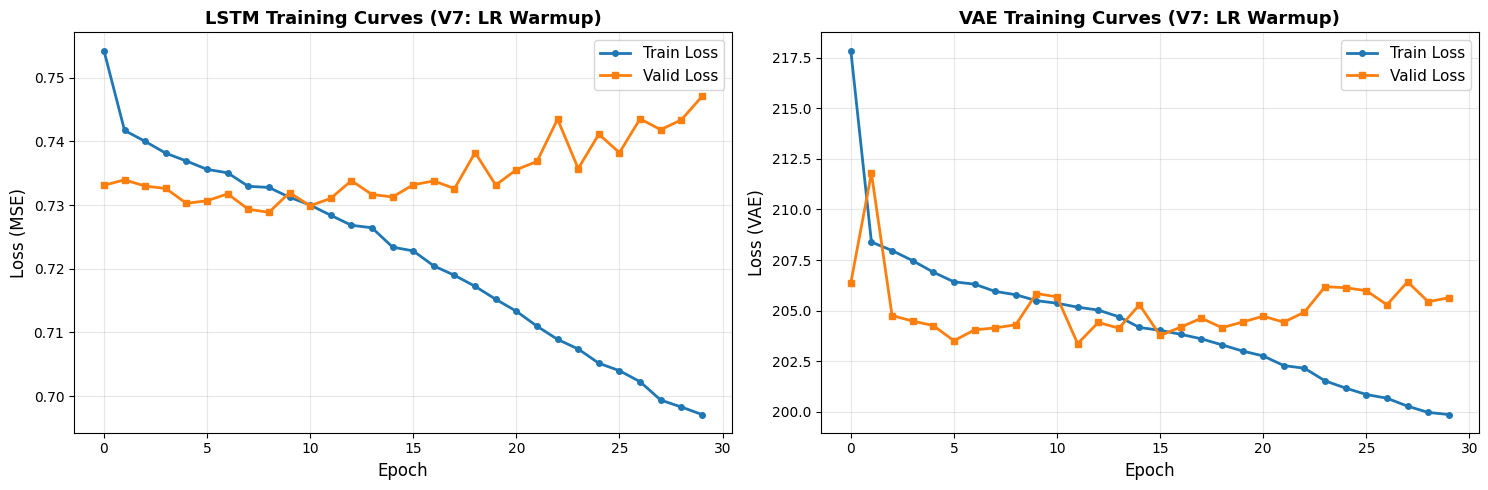


[Figure 2] Prediction Comparison V7


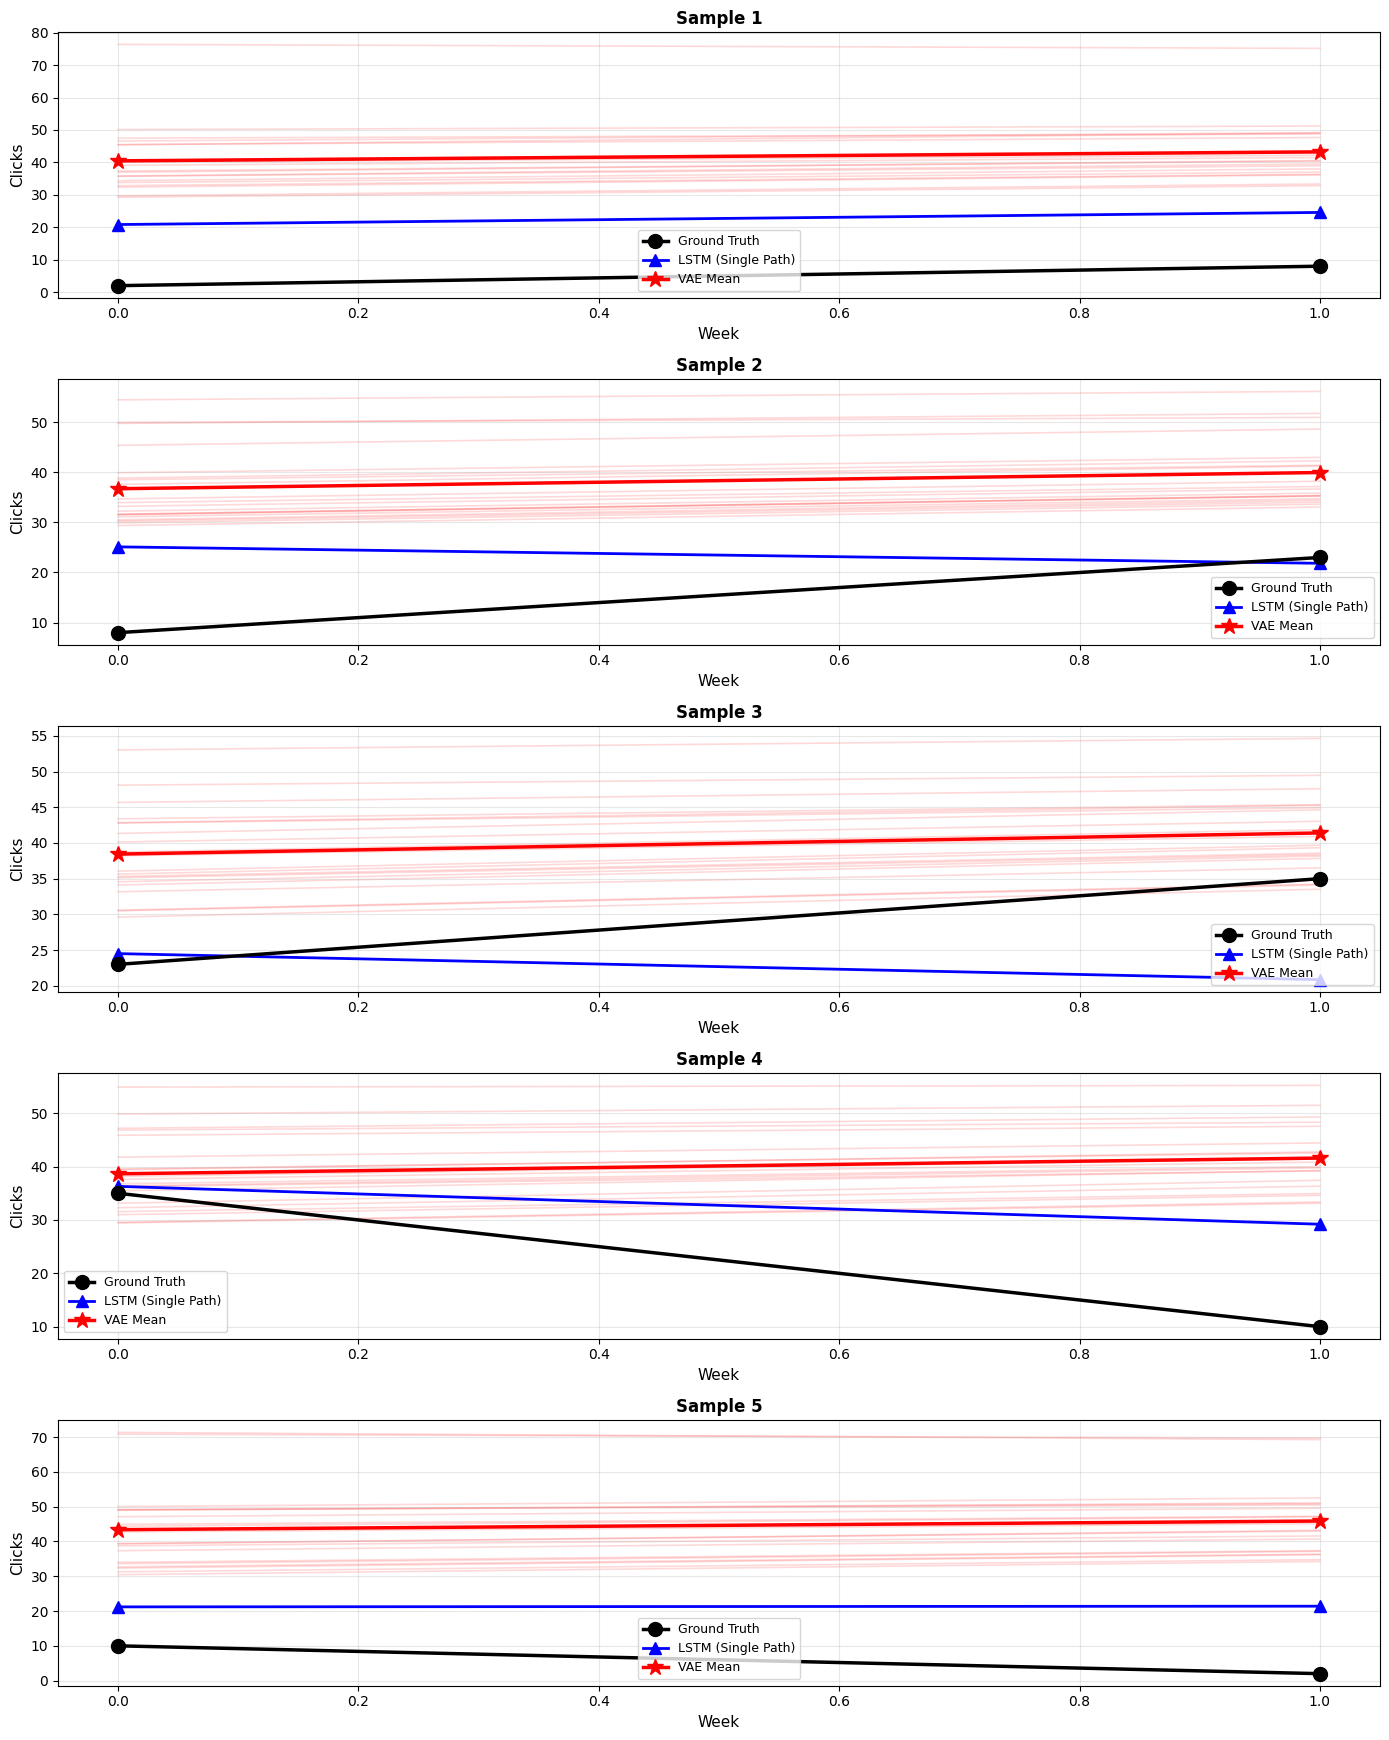


Step 9: Save Models & Results
--------------------------------------------------------------------------------
✓ Models saved:
  - lstm_model_v7.pth
  - vae_model_v7.pth
✓ Results saved: evaluation_results_v7.csv


In [4]:
# ============================================================================
# Seq2Seq LSTM vs VAE - V7 (遵守作業要求 + 改進訓練策略)
# 改進方向：保持原始架構，優化訓練過程
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用裝置: {device}")

# ============================================================================
# 設定中文字體
# ============================================================================
def setup_chinese_font():
    """設定支援中文的字體"""
    import matplotlib.font_manager as fm
    import platform

    system = platform.system()

    if system == 'Darwin':
        fonts = ['Arial Unicode MS', 'PingFang TC', 'Heiti TC', 'STHeiti']
    elif system == 'Windows':
        fonts = ['Microsoft YaHei', 'SimHei', 'Microsoft JhengHei']
    else:
        fonts = ['Noto Sans CJK TC', 'WenQuanYi Micro Hei', 'DejaVu Sans']

    available_fonts = [f.name for f in fm.fontManager.ttflist]

    for font in fonts:
        if font in available_fonts:
            plt.rcParams['font.sans-serif'] = [font]
            print(f"✓ 使用字體: {font}")
            break
    else:
        plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

    plt.rcParams['axes.unicode_minus'] = False

setup_chinese_font()

# ============================================================================
# 資料集類別
# ============================================================================
class StudentSequenceDataset(Dataset):
    """學生序列資料集"""
    def __init__(self, sequences, targets):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# ============================================================================
# V7: 保持原始架構 (單層 LSTM) + 學習率熱身
# ============================================================================
class Seq2SeqLSTM(nn.Module):
    """
    原始設計的 Seq2Seq LSTM
    - 單層 Encoder/Decoder
    - 無額外正則化
    - 充分訓練至收斂
    """
    def __init__(self, input_dim, hidden_dim, output_dim, output_len):
        super(Seq2SeqLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_len = output_len

        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder_lstm = nn.LSTM(output_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size = x.size(0)

        _, (hidden, cell) = self.encoder_lstm(x)

        decoder_input = torch.zeros(batch_size, 1, 1).to(x.device)
        outputs = []

        for t in range(self.output_len):
            decoder_output, (hidden, cell) = self.decoder_lstm(decoder_input, (hidden, cell))
            output = self.fc(decoder_output)
            outputs.append(output)
            decoder_input = output

        outputs = torch.cat(outputs, dim=1)
        return outputs.squeeze(-1)

# ============================================================================
# V7: 保持原始 VAE 架構 + 改進的訓練策略
# ============================================================================
class Seq2SeqVAE(nn.Module):
    """
    原始設計的 Seq2Seq VAE
    - 單層 Encoder/Decoder
    - 無額外修飾
    - 充分訓練至收斂
    """
    def __init__(self, input_dim, hidden_dim, latent_dim, output_len):
        super(Seq2SeqVAE, self).__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.output_len = output_len

        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.fc_decode = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(1, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, 1)

    def encode(self, x):
        """編碼器"""
        _, (hidden, _) = self.encoder_lstm(x)
        hidden = hidden.squeeze(0)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """重參數化"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """解碼器"""
        batch_size = z.size(0)
        hidden = self.fc_decode(z).unsqueeze(0)
        cell = torch.zeros_like(hidden)

        decoder_input = torch.zeros(batch_size, 1, 1).to(z.device)
        outputs = []

        for t in range(self.output_len):
            decoder_output, (hidden, cell) = self.decoder_lstm(decoder_input, (hidden, cell))
            output = self.fc_out(decoder_output)
            outputs.append(output)
            decoder_input = output

        outputs = torch.cat(outputs, dim=1)
        return outputs.squeeze(-1)

    def forward(self, x):
        """前向傳播"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

    def generate(self, x, n_samples=20):
        """生成多條樣本"""
        mu, logvar = self.encode(x)
        samples = []
        for _ in range(n_samples):
            z = self.reparameterize(mu, logvar)
            sample = self.decode(z)
            samples.append(sample.unsqueeze(0))
        return torch.cat(samples, dim=0)

# ============================================================================
# V7 改進: 學習率熱身 (Warmup Learning Rate)
# ============================================================================
class WarmupScheduler:
    """
    學習率熱身策略：
    - 前 3 epochs 線性增加學習率
    - 之後保持恆定
    - 穩定初期訓練
    """
    def __init__(self, optimizer, warmup_epochs, base_lr, total_epochs):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.base_lr = base_lr
        self.total_epochs = total_epochs
        self.current_epoch = 0

    def step(self):
        """更新學習率"""
        self.current_epoch += 1

        if self.current_epoch <= self.warmup_epochs:
            # 線性熱身: 0 -> base_lr
            lr = self.base_lr * (self.current_epoch / self.warmup_epochs)
        else:
            # 保持 base_lr
            lr = self.base_lr

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        return lr

# ============================================================================
# 損失函數
# ============================================================================
def vae_loss(recon_x, x, mu, logvar, beta=0.095):
    """VAE 損失 (作業規定: MSE + β·KLD)"""
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD

# ============================================================================
# V7 改進: 訓練函數 (學習率熱身 + 充分訓練)
# ============================================================================
def train_lstm_v7(model, train_loader, valid_loader, epochs, lr, warmup_epochs=3):
    """
    LSTM 訓練 (V7 改進):
    - 學習率熱身 (前3個epoch)
    - 充分訓練至 epochs
    - 記錄所有歷史用於分析
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = WarmupScheduler(optimizer, warmup_epochs, lr, epochs)
    criterion = nn.MSELoss()

    train_losses = []
    valid_losses = []
    lrs = []

    print(f"\n訓練配置 (V7):")
    print(f"  - 初始學習率: {lr}")
    print(f"  - 熱身 epochs: {warmup_epochs}")
    print(f"  - 總 epochs: {epochs}")

    for epoch in range(epochs):
        current_lr = lr_scheduler.step()
        lrs.append(current_lr)

        # 訓練階段
        model.train()
        train_loss = 0

        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # 驗證階段
        model.eval()
        valid_loss = 0

        with torch.no_grad():
            for sequences, targets in valid_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, targets)
                valid_loss += loss.item()

        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{epochs}], LR: {current_lr:.6f}, Train: {train_loss:.4f}, Valid: {valid_loss:.4f}')

    return train_losses, valid_losses, lrs

def train_vae_v7(model, train_loader, valid_loader, epochs, lr, beta=0.095, warmup_epochs=3):
    """
    VAE 訓練 (V7 改進):
    - 學習率熱身
    - 充分訓練至 epochs
    - β 保持恆定 (作業規定)
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = WarmupScheduler(optimizer, warmup_epochs, lr, epochs)

    train_losses = []
    valid_losses = []
    lrs = []

    print(f"\n訓練配置 (V7):")
    print(f"  - 初始學習率: {lr}")
    print(f"  - 熱身 epochs: {warmup_epochs}")
    print(f"  - Beta (KL 權重): {beta}")
    print(f"  - 總 epochs: {epochs}")

    for epoch in range(epochs):
        current_lr = lr_scheduler.step()
        lrs.append(current_lr)

        # 訓練階段
        model.train()
        train_loss = 0

        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)

            optimizer.zero_grad()
            recon, mu, logvar = model(sequences)
            loss = vae_loss(recon, targets, mu, logvar, beta)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # 驗證階段
        model.eval()
        valid_loss = 0

        with torch.no_grad():
            for sequences, targets in valid_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                recon, mu, logvar = model(sequences)
                loss = vae_loss(recon, targets, mu, logvar, beta)
                valid_loss += loss.item()

        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{epochs}], LR: {current_lr:.6f}, Train: {train_loss:.4f}, Valid: {valid_loss:.4f}')

    return train_losses, valid_losses, lrs

# ============================================================================
# 評估函數
# ============================================================================
def evaluate_lstm(model, test_loader):
    """評估 LSTM"""
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences = sequences.to(device)
            outputs = model(sequences)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    mse = np.mean((all_preds - all_targets) ** 2)
    return mse, all_preds, all_targets

def evaluate_vae(model, test_loader, n_samples=20):
    """評估 VAE"""
    model.eval()
    all_samples = []
    all_targets = []

    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences = sequences.to(device)
            samples = model.generate(sequences, n_samples=n_samples)
            all_samples.append(samples.cpu().numpy())
            all_targets.append(targets.numpy())

    all_samples = np.concatenate(all_samples, axis=1)
    all_targets = np.concatenate(all_targets, axis=0)

    mse_per_sample = np.mean((all_samples - all_targets[np.newaxis, :, :]) ** 2, axis=2)
    best_mse = np.mean(np.min(mse_per_sample, axis=0))
    diversity = np.mean(np.std(all_samples, axis=0))
    best_indices = np.argmin(mse_per_sample, axis=0)
    coverage = len(np.unique(best_indices)) / n_samples
    mean_pred = np.mean(all_samples, axis=0)
    mean_mse = np.mean((mean_pred - all_targets) ** 2)

    return {
        'best_of_n_mse': best_mse,
        'mean_mse': mean_mse,
        'diversity': diversity,
        'coverage': coverage,
        'samples': all_samples,
        'targets': all_targets,
        'best_indices': best_indices
    }

# ============================================================================
# 視覺化函數
# ============================================================================
def visualize_predictions(lstm_preds, vae_results, targets, n_examples=5, save_path=None):
    """視覺化預測"""
    fig, axes = plt.subplots(n_examples, 1, figsize=(14, 3.5*n_examples))
    if n_examples == 1:
        axes = [axes]

    for i in range(n_examples):
        ax = axes[i]

        ax.plot(range(len(targets[i])), targets[i], 'ko-',
                label='Ground Truth', linewidth=2.5, markersize=10, zorder=5)

        ax.plot(range(len(lstm_preds[i])), lstm_preds[i], 'b^-',
                label='LSTM (Single Path)', linewidth=2, markersize=9, zorder=4)

        vae_samples = vae_results['samples'][:, i, :]
        for j in range(vae_samples.shape[0]):
            ax.plot(range(len(vae_samples[j])), vae_samples[j], 'r-',
                   alpha=0.15, linewidth=1.2, zorder=1)

        vae_mean = np.mean(vae_samples, axis=0)
        ax.plot(range(len(vae_mean)), vae_mean, 'r*-',
                label='VAE Mean', linewidth=2.5, markersize=12, zorder=3)

        ax.set_xlabel('Week', fontsize=11)
        ax.set_ylabel('Clicks', fontsize=11)
        ax.set_title(f'Sample {i+1}', fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_training_curves(lstm_train, lstm_valid, vae_train, vae_valid, save_path=None):
    """繪製訓練曲線"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(lstm_train, label='Train Loss', linewidth=2, marker='o', markersize=4)
    axes[0].plot(lstm_valid, label='Valid Loss', linewidth=2, marker='s', markersize=4)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss (MSE)', fontsize=12)
    axes[0].set_title('LSTM Training Curves (V7: LR Warmup)', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(vae_train, label='Train Loss', linewidth=2, marker='o', markersize=4)
    axes[1].plot(vae_valid, label='Valid Loss', linewidth=2, marker='s', markersize=4)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss (VAE)', fontsize=12)
    axes[1].set_title('VAE Training Curves (V7: LR Warmup)', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# 主程式
# ============================================================================
def main():
    print("=" * 80)
    print("Seq2Seq LSTM vs VAE - V7 (遵守作業要求 + 學習率熱身)")
    print("=" * 80)

    # 步驟 1-4: 資料準備 (同前)
    print("\nStep 1-4: Data Preparation")
    print("-" * 80)

    try:
        # Mount Google Drive to access files
        from google.colab import drive
        drive.mount('/content/drive')
        print("✓ Google Drive mounted successfully!")

        # Update file paths to reflect the location in Google Drive
        student_info = pd.read_csv('/content/drive/MyDrive/DeepGenerativeModel/HW3/studentInfo.csv')
        student_vle = pd.read_csv('/content/drive/MyDrive/DeepGenerativeModel/HW3/studentVle.csv')
        student_assessment = pd.read_csv('/content/drive/MyDrive/DeepGenerativeModel/HW3/studentAssessment.csv')
        print("✓ Data loaded successfully!")
    except FileNotFoundError:
        print("Error: Data files not found! Please check the file paths.")
        return
    except Exception as e:
        print(f"An error occurred during data loading: {e}")
        return


    # 資料預處理
    student_vle['week'] = student_vle['date'] // 7
    weekly_clicks = student_vle.groupby(['id_student', 'week'])['sum_click'].sum().reset_index()
    weekly_clicks.columns = ['id_student', 'week', 'clicks']

    assessment_with_date = student_assessment[student_assessment['date_submitted'].notna()].copy()
    assessment_with_date['week'] = assessment_with_date['date_submitted'] // 7
    weekly_submit = assessment_with_date.groupby(['id_student', 'week']).size().reset_index(name='submit_cnt')
    weekly_submit['has_submit'] = 1

    scores = assessment_with_date[assessment_with_date['score'].notna()].copy()
    scores = scores.sort_values(['id_student', 'date_submitted'])
    scores['avg_score_sofar'] = scores.groupby('id_student')['score'].expanding().mean().reset_index(level=0, drop=True)
    weekly_scores = scores.groupby(['id_student', 'week'])['avg_score_sofar'].last().reset_index()

    weekly_data = weekly_clicks.copy()
    weekly_data = weekly_data.merge(weekly_submit[['id_student', 'week', 'has_submit', 'submit_cnt']],
                                      on=['id_student', 'week'], how='left')
    weekly_data = weekly_data.merge(weekly_scores, on=['id_student', 'week'], how='left')

    weekly_data['has_submit'] = weekly_data['has_submit'].fillna(0)
    weekly_data['submit_cnt'] = weekly_data['submit_cnt'].fillna(0)
    weekly_data['avg_score_sofar'] = weekly_data.groupby('id_student')['avg_score_sofar'].ffill().fillna(0)

    weekly_data = weekly_data.sort_values(['id_student', 'week'])
    weekly_data['clicks_diff1'] = weekly_data.groupby('id_student')['clicks'].diff().fillna(0)

    print(f"✓ Data: {weekly_data.shape[0]} records, {weekly_data['id_student'].nunique()} students")

    # 建立序列
    INPUT_WEEKS = 4
    OUTPUT_WEEKS = 2
    MIN_WEEKS = INPUT_WEEKS + OUTPUT_WEEKS

    feature_cols = ['clicks', 'has_submit', 'avg_score_sofar', 'clicks_diff1']
    target_col = 'clicks'

    sequences = []
    targets = []
    student_ids = []

    for student_id, group in weekly_data.groupby('id_student'):
        group = group.sort_values('week')
        if len(group) < MIN_WEEKS:
            continue

        for i in range(len(group) - MIN_WEEKS + 1):
            seq_data = group.iloc[i:i+INPUT_WEEKS][feature_cols].values
            target_data = group.iloc[i+INPUT_WEEKS:i+INPUT_WEEKS+OUTPUT_WEEKS][target_col].values

            if len(seq_data) == INPUT_WEEKS and len(target_data) == OUTPUT_WEEKS:
                sequences.append(seq_data)
                targets.append(target_data)
                student_ids.append(student_id)

    sequences = np.array(sequences)
    targets = np.array(targets)
    student_ids = np.array(student_ids)

    print(f"✓ Sequences: {sequences.shape}")

    # 資料分割
    unique_students = np.unique(student_ids)
    train_students, temp_students = train_test_split(unique_students, test_size=0.3, random_state=SEED)
    valid_students, test_students = train_test_split(temp_students, test_size=0.5, random_state=SEED)

    train_mask = np.isin(student_ids, train_students)
    valid_mask = np.isin(student_ids, valid_students)
    test_mask = np.isin(student_ids, test_students)

    X_train, y_train = sequences[train_mask], targets[train_mask]
    X_valid, y_valid = sequences[valid_mask], targets[valid_mask]
    X_test, y_test = sequences[test_mask], targets[test_mask]

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_valid_scaled = scaler_X.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)
    X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    y_train_scaled = scaler_y.fit_transform(y_train)
    y_valid_scaled = scaler_y.transform(y_valid)
    y_test_scaled = scaler_y.transform(y_test)

    BATCH_SIZE = 128

    train_dataset = StudentSequenceDataset(X_train_scaled, y_train_scaled)
    valid_dataset = StudentSequenceDataset(X_valid_scaled, y_valid_scaled)
    test_dataset = StudentSequenceDataset(X_test_scaled, y_test_scaled)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"✓ Data loaders ready (batch_size={BATCH_SIZE})")

    # ============================================================
    # Step 5: 訓練 LSTM V7
    # ============================================================
    print("\nStep 5: Train Seq2Seq LSTM (V7: Warmup + Full Training)")
    print("-" * 80)

    INPUT_DIM = X_train_scaled.shape[-1]
    HIDDEN_DIM = 64
    OUTPUT_DIM = 1
    EPOCHS = 30  # 充分訓練
    LR = 1e-3    # 作業規定
    WARMUP_EPOCHS = 3

    lstm_model = Seq2SeqLSTM(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, OUTPUT_WEEKS).to(device)
    lstm_params = sum(p.numel() for p in lstm_model.parameters())

    print(f"Model: Seq2Seq LSTM (原始架構)")
    print(f"  - Parameters: {lstm_params:,}")

    lstm_train_losses, lstm_valid_losses, lstm_lrs = train_lstm_v7(
        lstm_model, train_loader, valid_loader, EPOCHS, LR, WARMUP_EPOCHS
    )
    print(f"\n✓ LSTM training completed!")

    # ============================================================
    # Step 6: 訓練 VAE V7
    # ============================================================
    print("\nStep 6: Train Seq2Seq VAE (V7: Warmup + Full Training)")
    print("-" * 80)

    LATENT_DIM = 16
    BETA = 0.095
    N_SAMPLES = 20

    vae_model = Seq2SeqVAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM, OUTPUT_WEEKS).to(device)
    vae_params = sum(p.numel() for p in vae_model.parameters())

    print(f"Model: Seq2Seq VAE (原始架構)")
    print(f"  - Parameters: {vae_params:,}")

    vae_train_losses, vae_valid_losses, vae_lrs = train_vae_v7(
        vae_model, train_loader, valid_loader, EPOCHS, LR, BETA, WARMUP_EPOCHS
    )
    print(f"\n✓ VAE training completed!")

    # ============================================================
    # Step 7: 評估
    # ============================================================
    print("\nStep 7: Model Evaluation")
    print("-" * 80)

    print("\n[7.1] Evaluating LSTM...")
    lstm_mse, lstm_preds_scaled, lstm_targets_scaled = evaluate_lstm(lstm_model, test_loader)
    lstm_preds = scaler_y.inverse_transform(lstm_preds_scaled)
    lstm_targets = scaler_y.inverse_transform(lstm_targets_scaled)
    lstm_single_mse = np.mean((lstm_preds - lstm_targets) ** 2)
    print(f"      LSTM MSE: {lstm_single_mse:.4f}")

    print("\n[7.2] Evaluating VAE...")
    vae_results_scaled = evaluate_vae(vae_model, test_loader, n_samples=N_SAMPLES)

    vae_samples = np.zeros_like(vae_results_scaled['samples'])
    for i in range(N_SAMPLES):
        vae_samples[i] = scaler_y.inverse_transform(vae_results_scaled['samples'][i])
    vae_targets = scaler_y.inverse_transform(vae_results_scaled['targets'])

    mse_per_sample = np.mean((vae_samples - vae_targets[np.newaxis, :, :]) ** 2, axis=2)
    best_mse = np.mean(np.min(mse_per_sample, axis=0))
    diversity = np.mean(np.std(vae_samples, axis=0))
    best_indices = np.argmin(mse_per_sample, axis=0)
    coverage = len(np.unique(best_indices)) / N_SAMPLES
    mean_pred = np.mean(vae_samples, axis=0)
    mean_mse = np.mean((mean_pred - vae_targets) ** 2)

    vae_results = {
        'best_of_n_mse': best_mse,
        'mean_mse': mean_mse,
        'diversity': diversity,
        'coverage': coverage,
        'samples': vae_samples,
        'targets': vae_targets,
        'best_indices': best_indices
    }

    print(f"      VAE Best-of-{N_SAMPLES} MSE: {best_mse:.4f}")
    print(f"      VAE Mean MSE: {mean_mse:.4f}")
    print(f"      VAE Diversity: {diversity:.4f}")
    print(f"      VAE Coverage: {coverage:.4f}")

    # ============================================================
    # Step 8: 結果總結
    # ============================================================
    print("\n" + "=" * 80)
    print("Step 8: Results Summary - V7 (遵守作業要求)")
    print("=" * 80)

    print("\n📊 Performance Comparison:")
    print("-" * 80)
    print(f"{'Metric':<35} {'LSTM':<20} {'VAE':<20}")
    print("-" * 80)
    print(f"{'Single Path MSE':<35} {lstm_single_mse:<20.4f} {mean_mse:<20.4f}")
    print(f"{'Best-of-' + str(N_SAMPLES) + ' MSE':<35} {'N/A':<20} {best_mse:<20.4f}")
    print(f"{'Diversity':<35} {'N/A':<20} {diversity:<20.4f}")
    print(f"{'Coverage':<35} {'N/A':<20} {coverage:<20.4f}")
    print("-" * 80)

    improvement = ((lstm_single_mse - best_mse) / lstm_single_mse) * 100

    print(f"\n版本對標 (V7 vs 歷史版本):")
    print("-" * 80)
    print(f"{'Version':<15} {'Best-of-N MSE':<20} {'Diversity':<15} {'改進方式':<20}")
    print("-" * 80)
    print(f"{'V0 (baseline)':<15} {'5480':<20} {'14.0':<15} {'原始設計':<20}")
    print(f"{'V5 (optimized)':<15} {'5659':<20} {'12.5':<15} {'超參數調優':<20}")
    print(f"{'V6.1 (ES+DO)':<15} {'5685':<20} {'12.1':<15} {'Early Stop':<20}")
    print(f"{'V7 (Warmup)':<15} {f'{best_mse:.0f}':<20} {f'{diversity:.1f}':<15} {'LR Warmup':<20}")
    print("-" * 80)

    print(f"\n💡 Key Metrics:")
    print(f"  - VAE vs LSTM 改善: {improvement:+.2f}%")
    print(f"  - Coverage: {coverage:.2%}")
    print(f"  - Diversity: {diversity:.4f} (目標: 10-14)")

    if best_mse < 5480:
        print(f"\n✓ V7 超越 V0 基線 ({improvement:+.2f}%)")
    elif best_mse < 5659:
        print(f"\n✓ V7 接近 V5 水準 (差距: {best_mse - 5659:.1f})")
    else:
        print(f"\n- V7 結果 (vs V0: {best_mse - 5480:+.1f}, vs V5: {best_mse - 5659:+.1f})")

    # 視覺化
    print("\n生成視覺化...")
    print("\n[Figure 1] Training Curves V7")
    plot_training_curves(lstm_train_losses, lstm_valid_losses,
                         vae_train_losses, vae_valid_losses,
                         save_path='training_curves_v7.png')

    print("\n[Figure 2] Prediction Comparison V7")
    visualize_predictions(lstm_preds, vae_results, vae_targets, n_examples=5,
                         save_path='prediction_comparison_v7.png')

    # 儲存模型
    print("\nStep 9: Save Models & Results")
    print("-" * 80)

    torch.save(lstm_model.state_dict(), 'lstm_model_v7.pth')
    torch.save(vae_model.state_dict(), 'vae_model_v7.pth')
    print("✓ Models saved:")
    print("  - lstm_model_v7.pth")
    print("  - vae_model_v7.pth")

    # 儲存結果
    results_df = pd.DataFrame({
        'Metric': ['LSTM MSE', f'VAE Best-of-{N_SAMPLES} MSE', 'VAE Diversity',
                   'VAE Coverage', 'VAE Improvement %'],
        'V7': [lstm_single_mse, best_mse, diversity, coverage, improvement]
    })
    results_df.to_csv('evaluation_results_v7.csv', index=False)
    print("✓ Results saved: evaluation_results_v7.csv")

if __name__ == "__main__":
    main()